In [23]:

import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer

In [3]:
# ----------------------------------------
# 1. VERİ YÜKLEME
# ----------------------------------------
cv_df = pd.read_csv("cv_dataset.csv")
job_df = pd.read_csv("job_postings.csv")

In [5]:
# İlk 5 satırı görüntüle
print("🔹 CV Verisi:")
display(cv_df.head())

🔹 CV Verisi:


,ad_soyad,email,telefon,yetenekler,tecrube_yil,egitim,on_yazi
0,Dr. Vaysal Türk,erginel55@migros.net,Bilinmiyor,"React,TensorFlow,C#,HTML",20.0,Ön Lisans,Yeni teknolojileri öğrenmeye hevesli ve hızlı ...
1,Bergen Gök Zorlu Aksu,dilsitanzengin@camurcuoglu.biz,+90(247)216-6137x165,"TensorFlow,CSS,React,Python,Django,HTML",18.0,Lisans,"Takım çalışmasına uygun, öğrenmeye açık ve sor..."
2,Tayaydın Sezer,zalihabilir@hotmail.com,+90(663)3518180,"JavaScript,Python,SQL,React,TensorFlow,HTML",17.0,Lise,"Takım çalışmasına uygun, öğrenmeye açık ve sor..."
3,Dr. Seracettin Jankat Gülen,rduran@bim.info,+90(775)491-6906x2160,"JavaScript,HTML,Django,React,Java,TensorFlow",9.0,Ön Lisans,İlgili alandaki tecrübelerim ve becerilerim do...
4,Türcan Saire Yıldırım,ademirel@arcelik.net,+90(069)4591436,"Python,React,JavaScript",3.0,Yüksek Lisans,Bilgi verilmemiş


In [7]:
print("🔹 İş İlanı Verisi:")
display(job_df.head())

🔹 İş İlanı Verisi:


,pozisyon,sirket,sehir,aciklama,gereksinimler
0,Veri Analisti,BüyükVeri Ltd.,Belirtilmemiş,"Frontend projelerinde görev alacak, React ve J...",Üniversitelerin ilgili bölümlerinden mezun olm...
1,Veri Mühendisi,Mobilify,Bursa,"Frontend projelerinde görev alacak, React ve J...","Yeni teknolojileri öğrenmeye açıklık, Problem ..."
2,Frontend Developer,KodaYazılım,Eskişehir,"Makine öğrenmesi projelerinde çalışacak, Tenso...","Yeni teknolojileri öğrenmeye açıklık, Takım ça..."
3,Makine Öğrenmesi Uzmanı,Techsoft,Ankara,"Frontend projelerinde görev alacak, React ve J...","En az 3 yıl yazılım geliştirme deneyimi, Yeni ..."
4,Python Geliştiricisi,KodaYazılım,Kocaeli,Belirtilmemiş,"En az 3 yıl yazılım geliştirme deneyimi, Ünive..."


In [9]:
# Sütun bilgileri
print("🔹 CV Veri Seti Sütunları:", cv_df.columns.tolist())
print("🔹 İlan Veri Seti Sütunları:", job_df.columns.tolist())


🔹 CV Veri Seti Sütunları: ['ad_soyad', 'email', 'telefon', 'yetenekler', 'tecrube_yil', 'egitim', 'on_yazi']
🔹 İlan Veri Seti Sütunları: ['pozisyon', 'sirket', 'sehir', 'aciklama', 'gereksinimler']


In [11]:
# Satır sayıları
print(f"CV veri seti satır sayısı: {len(cv_df)}")
print(f"İlan veri seti satır sayısı: {len(job_df)}")

CV veri seti satır sayısı: 4998
İlan veri seti satır sayısı: 5200


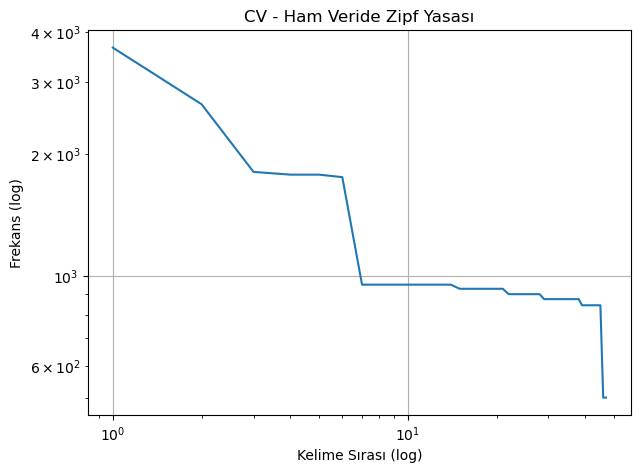

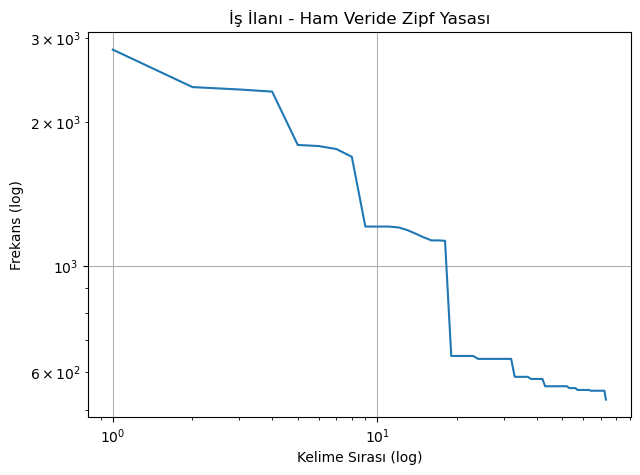

In [15]:
# ----------------------------------------
# 2. ZIPF YASASI - HAM VERİ
# ----------------------------------------

def temizle_metni(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zçğıöşü\s]", "", text)
    return text

def zipf_plot(freq_dict, title):
    freqs = list(freq_dict.values())
    freqs.sort(reverse=True)
    ranks = range(1, len(freqs) + 1)
    plt.figure(figsize=(7,5))
    plt.loglog(ranks, freqs)
    plt.title(title)
    plt.xlabel("Kelime Sırası (log)")
    plt.ylabel("Frekans (log)")
    plt.grid(True)
    plt.show()

cv_text_raw = " ".join(cv_df["on_yazi"].map(temizle_metni))
job_text_raw = " ".join(job_df["aciklama"].map(temizle_metni))

cv_freq = Counter(cv_text_raw.split())
job_freq = Counter(job_text_raw.split())

zipf_plot(cv_freq, "CV - Ham Veride Zipf Yasası")
zipf_plot(job_freq, "İş İlanı - Ham Veride Zipf Yasası")


In [25]:
# ----------------------------------------
# 3. LEMMATIZATION & STEMMING
# ----------------------------------------

stop_words = set(stopwords.words("turkish"))
stemmer = PorterStemmer()  # Snowball yerine Porter kullan

stop_words = set(stopwords.words("turkish"))

def preprocess_sentence_tr(sentence):
    tokens = word_tokenize(str(sentence), language="turkish")
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return filtered_tokens, stemmed_tokens,

def uygulamali_temizleme(df, column):
    lemma_corpus, stem_corpus = [], []

    for cumle in df[column].tolist():
        lemma, stem = preprocess_sentence_tr(cumle)
        lemma_corpus.append(lemma)
        stem_corpus.append(stem)

    df_lemma = pd.DataFrame({column: [" ".join(l) for l in lemma_corpus]})
    df_stem = pd.DataFrame({column: [" ".join(s) for s in stem_corpus]})
    return df_lemma, df_stem

cv_lemma_df, cv_stem_df = uygulamali_temizleme(cv_df, "on_yazi")
job_lemma_df, job_stem_df = uygulamali_temizleme(job_df, "aciklama")

cv_lemma_df.to_csv("cv_lemmatized.csv", index=False)
cv_stem_df.to_csv("cv_stemmed.csv", index=False)
job_lemma_df.to_csv("job_lemmatized.csv", index=False)
job_stem_df.to_csv("job_stemmed.csv", index=False)

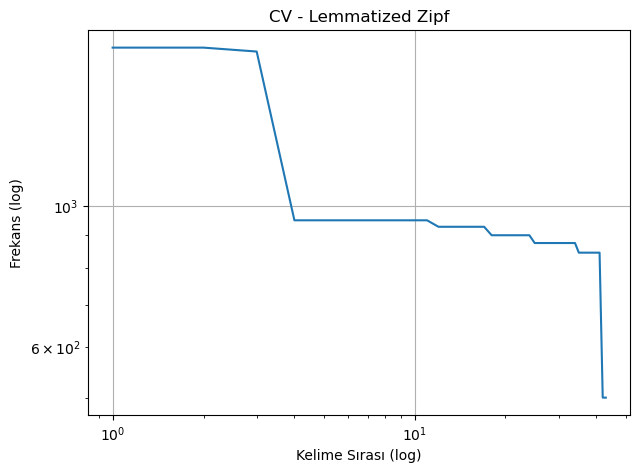

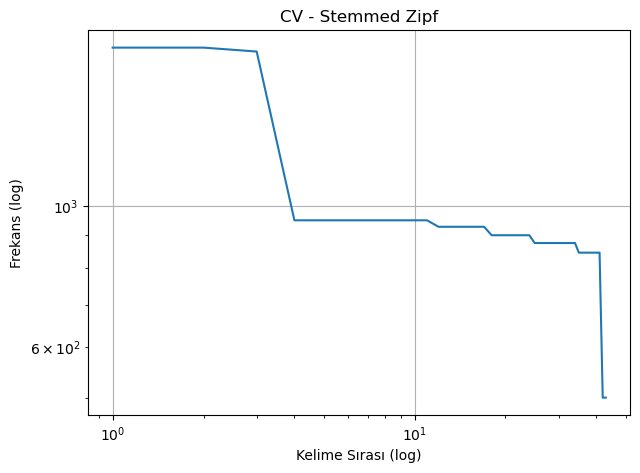

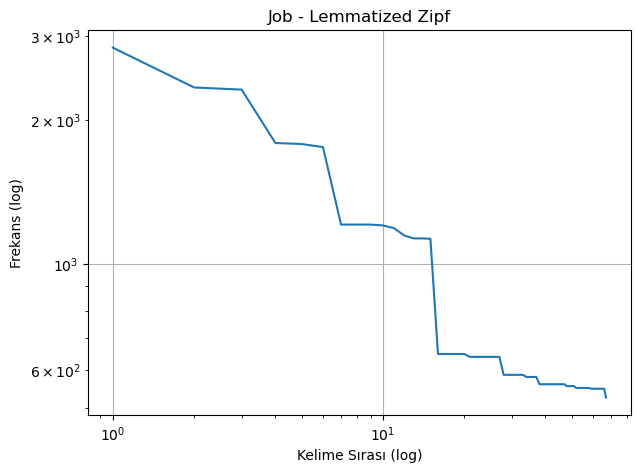

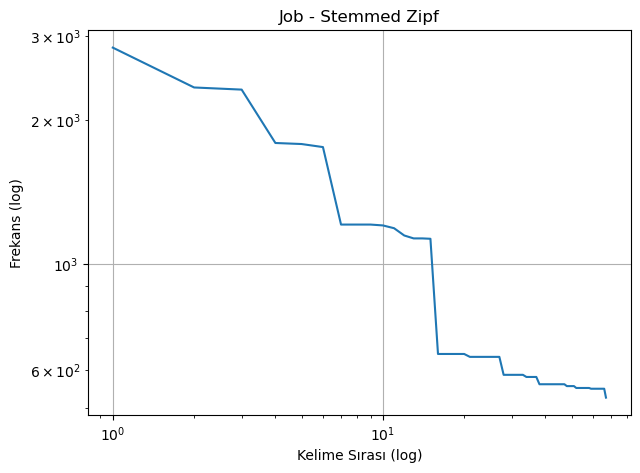

In [27]:
# ----------------------------------------
# 4. ZIPF - TEMİZLENMİŞ VERİ
# ----------------------------------------

zipf_plot(Counter(" ".join(cv_lemma_df["on_yazi"]).split()), "CV - Lemmatized Zipf")
zipf_plot(Counter(" ".join(cv_stem_df["on_yazi"]).split()), "CV - Stemmed Zipf")
zipf_plot(Counter(" ".join(job_lemma_df["aciklama"]).split()), "Job - Lemmatized Zipf")
zipf_plot(Counter(" ".join(job_stem_df["aciklama"]).split()), "Job - Stemmed Zipf")

In [29]:
# ----------------------------------------
# 5. TF-IDF VEKTÖRLEŞTİRME (STEMMED VERİLER ÜZERİNDE)
# ----------------------------------------

def tfidf_vektorleştir(df, metin_sutunu, output_path):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[metin_sutunu])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    tfidf_df.to_csv(output_path, index=False)
    return tfidf_df

# Sadece stemmed veriler başarılı olduğu için onları kullanıyoruz
tfidf_cv_stem = tfidf_vektorleştir(cv_stem_df, "on_yazi", "tfidf_stemmed_cv.csv")
tfidf_job_stem = tfidf_vektorleştir(job_stem_df, "aciklama", "tfidf_stemmed_job.csv")

In [31]:
def train_and_save_model(corpus, params, model_name_prefix):
    model = Word2Vec(
        sentences=corpus,
        vector_size=params["vector_size"],
        window=params["window"],
        min_count=1,
        sg=1 if params["model_type"] == "skipgram" else 0
    )
    model_name = f"{model_name_prefix}_{params['model_type']}_window{params['window']}_dim{params['vector_size']}.model"
    model.save(model_name)
    print(f"✅ {model_name} modeli kaydedildi.")

In [35]:
parameters = [
    {'model_type': 'cbow', 'window': 2, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 2, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 300},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 300}
]

In [37]:
# Cümle listelerini tekrar tokenize edilmiş haliyle oluştur
cv_lemma_corpus = [sentence.split() for sentence in cv_lemma_df["on_yazi"].dropna()]
cv_stem_corpus = [sentence.split() for sentence in cv_stem_df["on_yazi"].dropna()]
job_lemma_corpus = [sentence.split() for sentence in job_lemma_df["aciklama"].dropna()]
job_stem_corpus = [sentence.split() for sentence in job_stem_df["aciklama"].dropna()]

In [39]:
# Lemmatized modelleri eğit
for param in parameters:
    train_and_save_model(cv_lemma_corpus, param, "cv_lemmatized_model")
    train_and_save_model(job_lemma_corpus, param, "job_lemmatized_model")

# Stemmed modelleri eğit
for param in parameters:
    train_and_save_model(cv_stem_corpus, param, "cv_stemmed_model")
    train_and_save_model(job_stem_corpus, param, "job_stemmed_model")

✅ cv_lemmatized_model_cbow_window2_dim100.model modeli kaydedildi.
✅ job_lemmatized_model_cbow_window2_dim100.model modeli kaydedildi.
✅ cv_lemmatized_model_skipgram_window2_dim100.model modeli kaydedildi.
✅ job_lemmatized_model_skipgram_window2_dim100.model modeli kaydedildi.
✅ cv_lemmatized_model_cbow_window4_dim100.model modeli kaydedildi.
✅ job_lemmatized_model_cbow_window4_dim100.model modeli kaydedildi.
✅ cv_lemmatized_model_skipgram_window4_dim100.model modeli kaydedildi.
✅ job_lemmatized_model_skipgram_window4_dim100.model modeli kaydedildi.
✅ cv_lemmatized_model_cbow_window2_dim300.model modeli kaydedildi.
✅ job_lemmatized_model_cbow_window2_dim300.model modeli kaydedildi.
✅ cv_lemmatized_model_skipgram_window2_dim300.model modeli kaydedildi.
✅ job_lemmatized_model_skipgram_window2_dim300.model modeli kaydedildi.
✅ cv_lemmatized_model_cbow_window4_dim300.model modeli kaydedildi.
✅ job_lemmatized_model_cbow_window4_dim300.model modeli kaydedildi.
✅ cv_lemmatized_model_skipgram_

In [41]:

def print_similar_words(model_path, keyword):
    model = Word2Vec.load(model_path)
    print(f"📌 Model: {model_path}")
    try:
        similar = model.wv.most_similar(keyword, topn=5)
        for word, score in similar:
            print(f"  ➤ {word} (Benzerlik: {score:.4f})")
    except KeyError:
        print(f"  ❗ '{keyword}' kelimesi modelde bulunamadı.")
    print("\n")

In [43]:
print_similar_words("cv_stemmed_model_skipgram_window4_dim300.model", "veri")
print_similar_words("cv_lemmatized_model_cbow_window2_dim100.model", "python")
print_similar_words("cv_stemmed_model_cbow_window2_dim100.model", "takım")


📌 Model: cv_stemmed_model_skipgram_window4_dim300.model
  ❗ 'veri' kelimesi modelde bulunamadı.


📌 Model: cv_lemmatized_model_cbow_window2_dim100.model
  ❗ 'python' kelimesi modelde bulunamadı.


📌 Model: cv_stemmed_model_cbow_window2_dim100.model
  ➤ sahibi (Benzerlik: 0.9957)
  ➤ çalışmasına (Benzerlik: 0.9953)
  ➤ açık (Benzerlik: 0.9951)
  ➤ sorumluluk (Benzerlik: 0.9944)
  ➤ uygun (Benzerlik: 0.9884)




In [45]:
# En başarılı modelin yüklenmesi
model = Word2Vec.load("cv_stemmed_model_cbow_window2_dim100.model")

In [47]:

# Vektöre dönüştürme fonksiyonu
def text_to_vector(text, model):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

In [49]:
# CV ve ilan vektörlerini hesapla
cv_vectors = cv_stem_df["on_yazi"].apply(lambda x: text_to_vector(x, model)).tolist()
job_vectors = job_stem_df["aciklama"].apply(lambda x: text_to_vector(x, model)).tolist()

In [51]:
# ----------------------------------------
# 7. EŞLEŞME ANALİZİ
# ----------------------------------------

top_matches = {}

for i, job_vec in enumerate(job_vectors):
    sims = cosine_similarity([job_vec], cv_vectors)[0]
    top_5 = np.argsort(sims)[-5:][::-1]
    top_matches[i] = list(zip(top_5, sims[top_5]))

In [53]:
# Örnek çıktı
for job_id in range(3):
    print(f"\n🔹 İlan {job_id} için en uygun 5 CV:")
    for cv_index, score in top_matches[job_id]:
        isim = cv_df.iloc[cv_index]["ad_soyad"]
        print(f"  ➤ {isim} | Benzerlik Skoru: {score:.4f}")


🔹 İlan 0 için en uygun 5 CV:
  ➤ Siti Misra Demir | Benzerlik Skoru: 0.9746
  ➤ Dr. Alaz Fayize Erdoğan | Benzerlik Skoru: 0.9746
  ➤ Uçan Sakarya | Benzerlik Skoru: 0.9746
  ➤ Bilginur Şener | Benzerlik Skoru: 0.9746
  ➤ Bay Tanır Haluk Aslan | Benzerlik Skoru: 0.9746

🔹 İlan 1 için en uygun 5 CV:
  ➤ Siti Misra Demir | Benzerlik Skoru: 0.9746
  ➤ Dr. Alaz Fayize Erdoğan | Benzerlik Skoru: 0.9746
  ➤ Uçan Sakarya | Benzerlik Skoru: 0.9746
  ➤ Bilginur Şener | Benzerlik Skoru: 0.9746
  ➤ Bay Tanır Haluk Aslan | Benzerlik Skoru: 0.9746

🔹 İlan 2 için en uygun 5 CV:
  ➤ Meleknur Mansız Tarhan | Benzerlik Skoru: 0.9967
  ➤ Dr. Güldünya Ceyhun Yorulmaz | Benzerlik Skoru: 0.9967
  ➤ Oğuzman Saydam Ülker Dumanlı | Benzerlik Skoru: 0.9967
  ➤ Dr. Alaz Fayize Erdoğan | Benzerlik Skoru: 0.9967
  ➤ Atnan Hayali Bilge | Benzerlik Skoru: 0.9967
